In [1]:
using RxInfer, Distributions, LinearAlgebra, Random, Plots, BenchmarkTools, Parameters

In [2]:
module Parallel
	include("../parallel.jl")
end

Main.Parallel

In [3]:
Threads.nthreads()

2

In [4]:
function generate_ar_data(rng, n, θ, γ, τ)
    order        = length(θ)
    states       = Vector{Vector{Float64}}(undef, n + 3order)
    observations = Vector{Float64}(undef, n + 3order)

    γ_std = sqrt(inv(γ))
    τ_std = sqrt(inv(τ))

    states[1] = randn(rng, order)

    for i in 2:(n + 3order)
        states[i]       = vcat(rand(rng, Normal(dot(θ, states[i - 1]), γ_std)), states[i-1][1:end-1])
        observations[i] = rand(rng, Normal(states[i][1], τ_std))
    end

    return states[1+3order:end], observations[1+3order:end]
end

generate_ar_data (generic function with 1 method)

In [5]:
@model function lar_model(T::Type, n, order, c, τ, prod_strategy, pipeline)
    # We create a sequence of random variables for hidden states
    x = randomvar(n) where { prod_strategy = prod_strategy }
    # As well a sequence of observartions
    y = datavar(Float64, n)

    ct = constvar(c)
    # We assume observation noise to be known
    cτ = constvar(τ)

    γ  = randomvar() where { prod_strategy = prod_strategy }
    θ  = randomvar() where { prod_strategy = prod_strategy }
    x0 = randomvar() where { prod_strategy = prod_strategy }

    # Prior for first state
    if T === Multivariate
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ MvNormal(μ = zeros(order), Λ = diageye(order))
        x0 ~ MvNormal(μ = zeros(order), Λ = diageye(order))
    else
        γ  ~ Gamma(α = 1.0, β = 1.0)
        θ  ~ Normal(μ = 0.0, γ = 1.0)
        x0 ~ Normal(μ = 0.0, γ = 1.0)
    end

    x_prev = x0

    for i in 1:n

        x[i] ~ AR(x_prev, θ, γ) where { pipeline = pipeline }

        if T === Multivariate
            y[i] ~ Normal(μ = dot(ct, x[i]), γ = cτ) where { pipeline = pipeline }
        else
            y[i] ~ Normal(μ = ct * x[i], γ = cτ) where { pipeline = pipeline }
        end

        x_prev = x[i]
    end
end

In [6]:
@constraints function ar_constraints()
    q(x0, x, θ, γ) = q(x0, x)q(θ)q(γ)
end

@meta function ar_meta(artype, order, stype)
    AR() -> ARMeta(artype, order, stype)
end

ar_meta (generic function with 1 method)

In [7]:
martype = Multivariate
moptions = (limit_stack_depth = 100, )
mreturnvars = (x = KeepLast(), γ = KeepEach(), θ = KeepEach())
mconstraints = ar_constraints()

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x0, x, θ, γ) = q(x0, x)q(θ)q(γ)
Options:
  warn = true


In [8]:
# Seed for reproducibility
seed = 123
rng  = MersenneTwister(seed)

# AR process parameters
real_γ = 1.0
real_τ = 0.5
real_θ = [0.10699399235785655, -0.5237303489793305, 0.3068897071844715, -0.17232255282458891, 0.13323964347539288];

In [9]:
function run_test(prod_strategy, pipeline, order, n)
	mc = ReactiveMP.ar_unit(martype, order)
	mmeta = ar_meta(martype, order, ARsafe())
	minitmarginals = (γ = GammaShapeRate(1.0, 1.0), θ = MvNormalMeanPrecision(zeros(order), diageye(order)))
	states, observations = generate_ar_data(rng, n, real_θ, real_γ, real_τ);
	mdata = (y = observations, )

	b = @benchmark infer(
	    model = lar_model(martype, $n, $order, $mc, real_τ, $prod_strategy, $pipeline),
	    data  = $mdata,
	    constraints   = mconstraints,
	    meta          = $mmeta,
	    options       = moptions,
	    initmarginals = $minitmarginals,
	    returnvars    = mreturnvars,
	    free_energy   = true,
	    iterations    = 50,
	    showprogress  = false
	)

	return mean(b.times)
end

run_test (generic function with 1 method)

In [10]:
function test_rule_performance(ar_order)
	m_y = MvNormalMeanCovariance(zeros(ar_order), diageye(ar_order))
	m_x = MvNormalMeanCovariance(zeros(ar_order), diageye(ar_order))
	q_θ = MvNormalMeanCovariance(zeros(ar_order), diageye(ar_order))
	q_γ = Gamma(1, 1)
	meta = ARMeta(martype, ar_order, ARsafe())

	x_rule = @call_rule AR(:x, ReactiveMP.Marginalisation) (m_y = m_y, q_θ = q_θ, q_γ = q_γ, meta = meta)
	y_rule = @call_rule AR(:y, ReactiveMP.Marginalisation) (m_x = m_x, q_θ = q_θ, q_γ = q_γ, meta = meta)
	x_y_rule = @call_marginalrule AR(:y_x) (m_y = m_y, m_x = m_x, q_θ = q_θ, q_γ = q_γ, meta = meta)
	θ_rule = @call_rule AR(:θ, ReactiveMP.Marginalisation) (q_y_x = x_y_rule, q_γ = q_γ, meta = meta)
	γ_rule = @call_rule AR(:γ, ReactiveMP.Marginalisation) (q_y_x = x_y_rule, q_θ = q_θ, meta = meta)

	return (x_rule, y_rule, θ_rule, γ_rule)
end

test_rule_performance (generic function with 1 method)

In [11]:
orders = [5, 10, 20, 40]
rule_time = Vector{Float64}(undef, length(orders))
time_s = Vector{Float64}(undef, length(orders))
time_p = Vector{Float64}(undef, length(orders))
time_p_blocking = Vector{Float64}(undef, length(orders))
time_p_donefirst = Vector{Float64}(undef, length(orders))
time_blocking = Vector{Float64}(undef, length(orders))
n = 1000;

In [12]:
for i in eachindex(orders)
    println("Evaluating AR model with order: $(orders[i]) and samples: $n")
    b = @benchmark test_rule_performance($orders[$i])
    rule_time[i] = mean(b.times)
    time_s[i] = run_test(nothing, nothing, orders[i], n)
    #time_p[i] = run_test(nothing, Parallel.ThreadsPipelineStage(), orders[i], n)
    time_p_blocking[i] = run_test(Parallel.CustomProdStrategy(Parallel.blocking_parallel_prod), Parallel.ThreadsPipelineStage(), orders[i], n)
    time_p_donefirst[i] = run_test(Parallel.CustomProdStrategy(Parallel.done_first_parallel_prod), Parallel.ThreadsPipelineStage(), orders[i], n)
    #time_blocking[i] = run_test(Parallel.CustomProdStrategy(Parallel.blocking_parallel_prod), nothing, orders[i], n)
end

Evaluating AR model with order: 5 and samples: 1000

Evaluating AR model with order: 10 and samples: 1000


Evaluating AR model with order: 20 and samples: 1000

Evaluating AR model with order: 40 and samples: 1000

In [13]:
#rel_speed_p = time_s ./ time_p
rel_speed_p_blocking = time_s ./ time_p_blocking
rel_speed_p_donefirst = time_s ./ time_p_donefirst
#rel_speed_blocking = time_s ./ time_blocking
rule_time_ms = rule_time / 1000;

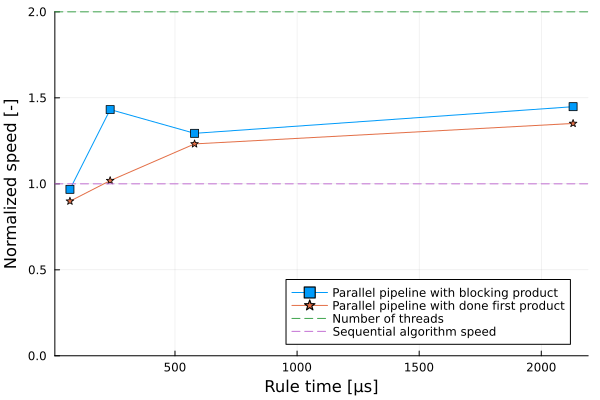

In [14]:
#plot(rule_time_ms, rel_speed_p, markershape=:circle, label="Parallel pipeline")
plot(rule_time_ms, rel_speed_p_blocking, markershape=:rect, label="Parallel pipeline with blocking product")
plot!(rule_time_ms, rel_speed_p_donefirst, markershape=:star5, label="Parallel pipeline with done first product")
#plot!(rule_time_ms, rel_speed_blocking, markershape=:diamond, label="Blocking product")
hline!([Threads.nthreads()], linestyle=:dash, label="Number of threads")
hline!([1], linestyle=:dash, label="Sequential algorithm speed", ylim=(0, Threads.nthreads()), xlabel="Rule time [μs]", ylabel="Normalized speed [-]")